In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from tqdm import tqdm
tqdm.pandas()
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support, auc, roc_curve
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

In [4]:
na = pd.read_csv(r"D:\Work\Internshala\NLP\data_news.csv")

In [6]:
na.head()

,category,headline,links,short_description,keywords
0,WELLNESS,143 Miles in 35 Days: Lessons Learned,https://www.huffingtonpost.com/entry/running-l...,Resting is part of training. I've confirmed wh...,running-lessons
1,WELLNESS,Talking to Yourself: Crazy or Crazy Helpful?,https://www.huffingtonpost.com/entry/talking-t...,Think of talking to yourself as a tool to coac...,talking-to-yourself-crazy
2,WELLNESS,Crenezumab: Trial Will Gauge Whether Alzheimer...,https://www.huffingtonpost.com/entry/crenezuma...,The clock is ticking for the United States to ...,crenezumab-alzheimers-disease-drug
3,WELLNESS,"Oh, What a Difference She Made",https://www.huffingtonpost.com/entry/meaningfu...,"If you want to be busy, keep trying to be perf...",meaningful-life
4,WELLNESS,Green Superfoods,https://www.huffingtonpost.com/entry/green-sup...,"First, the bad news: Soda bread, corned beef a...",green-superfoods


# Data Collection and Preprocessing

In [9]:
na.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   category           50000 non-null  object
 1   headline           50000 non-null  object
 2   links              50000 non-null  object
 3   short_description  50000 non-null  object
 4   keywords           47332 non-null  object
dtypes: object(5)
memory usage: 1.9+ MB


In [12]:
#Fill missing keywords with "" (empty string).
# When you use TF-IDF or CountVectorizer, missing values won’t break pipeline.

na['keywords'] = na['keywords'].fillna('')

In [14]:
duplicates = na.duplicated(subset=['headline', 'short_description'])
print("Number of duplicates based on headline + description:", duplicates.sum())

# Show duplicate rows
na[duplicates]

Number of duplicates based on headline + description: 4251


,category,headline,links,short_description,keywords
40027,BUSINESS,The 10 Cities With The Longest Work Weeks,https://www.huffingtonpost.com/entry/cities-lo...,Feeling overworked? Moving to a different city...,cities-longest-work-weeks
40089,BUSINESS,10 States Where People Drink The Most Beer,https://www.huffingtonpost.com/entry/states-be...,(Hat tip: UPI) We are a nation of beer drinker...,states-beer-per-capita-consumption
40095,BUSINESS,"Women in Business: Q&A with Venus Hurst, Found...",https://www.huffingtonpost.com/entry/women-in-...,Venus Hurst is no stranger to entrepreneurship...,women-in-business-qa-with
40119,BUSINESS,Hiring Guru: Nationwide Debt Direct Hires for ...,https://www.huffingtonpost.com/entry/hiring-gu...,Jeffrey DeLage is Chief Operating Officer of N...,hiring-guru-nationwide-de
40134,BUSINESS,10 Things To Immediately Do If You Want Your S...,https://www.huffingtonpost.com/entry/10-things...,"According to SBA data, “at least 25% of small ...",10-things-to-immediately-do-if-you-want-your-s...
...,...,...,...,...,...
49992,SPORTS,Terrence Ross Dunk Contest Video: Raptors' Roo...,https://www.huffingtonpost.com/entry/terrence-...,"Whether or not Shaq knew him, Ross figures to ...",terrence-ross-dunk-contest-winner-2013-video
49993,SPORTS,Norovirus Outbreak At Winter Olympics Prompts ...,https://www.huffingtonpost.com/entry/norovirus...,Troops will replace hundreds of civilian secur...,norovirus-outbreak-at-winter-olympics-prompts-...
49994,SPORTS,"Tiger Woods And Rory McIlroy, Honda Classic Li...",https://www.huffingtonpost.comhttp://golfweek....,Tiger Woods is looking to springboard off a 5-...,
49997,SPORTS,Rasheed Wallace Ejected From Knicks-Suns Game ...,https://www.huffingtonpost.com/entry/rasheed-w...,Wallace was hit with a first technical for a h...,rasheed-wallace-ejected-knicks-suns-ball-dont-lie


In [16]:
## Duplicates

In [18]:
na.duplicated().sum()

4251

In [20]:
na.drop_duplicates(inplace=True)

In [22]:
na.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45749 entries, 0 to 49999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   category           45749 non-null  object
 1   headline           45749 non-null  object
 2   links              45749 non-null  object
 3   short_description  45749 non-null  object
 4   keywords           45749 non-null  object
dtypes: object(5)
memory usage: 2.1+ MB


In [24]:
na['category'].value_counts()

category
WELLNESS          5000
POLITICS          5000
ENTERTAINMENT     5000
TRAVEL            5000
STYLE & BEAUTY    5000
PARENTING         5000
FOOD & DRINK      5000
WORLD NEWS        5000
BUSINESS          3091
SPORTS            2658
Name: count, dtype: int64

## Preprocessing

In [27]:
na.head()

,category,headline,links,short_description,keywords
0,WELLNESS,143 Miles in 35 Days: Lessons Learned,https://www.huffingtonpost.com/entry/running-l...,Resting is part of training. I've confirmed wh...,running-lessons
1,WELLNESS,Talking to Yourself: Crazy or Crazy Helpful?,https://www.huffingtonpost.com/entry/talking-t...,Think of talking to yourself as a tool to coac...,talking-to-yourself-crazy
2,WELLNESS,Crenezumab: Trial Will Gauge Whether Alzheimer...,https://www.huffingtonpost.com/entry/crenezuma...,The clock is ticking for the United States to ...,crenezumab-alzheimers-disease-drug
3,WELLNESS,"Oh, What a Difference She Made",https://www.huffingtonpost.com/entry/meaningfu...,"If you want to be busy, keep trying to be perf...",meaningful-life
4,WELLNESS,Green Superfoods,https://www.huffingtonpost.com/entry/green-sup...,"First, the bad news: Soda bread, corned beef a...",green-superfoods


In [29]:
def clean_links(text):
    text = str(text)
    # Extract everything after '/entry/' if it exists
    text = re.sub(r'.*/entry/', '', text)
    # Replace underscores/hyphens with spaces
    text = re.sub(r'[_\-]', ' ', text)
    # Remove hash-like tokens (letters+digits mixed, usually long)
    text = re.sub(r'\b[a-zA-Z]*\d+[a-zA-Z\d]*\b', '', text)
    # Keep only letters and spaces
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Normalize
    text = text.lower()
    text = ' '.join(text.split())
    return text


In [31]:
txt = na['links'][0]
txt

'https://www.huffingtonpost.com/entry/running-lessons_us_5b9dc0a4e4b03a1dcc8c72d1'

In [33]:

cleaned_txt = clean_links(txt)
cleaned_txt

'running lessons us'

In [35]:
na['links_clean'] = na['links'].progress_apply(clean_links)

100%|█████████████████████████████████████████████████████████████████████████| 45749/45749 [00:01<00:00, 27830.00it/s]


In [37]:
na['links_clean']

0                                   running lessons us
1                         talking to yourself crazy us
2                crenezumab alzheimers disease drug us
3                                   meaningful life us
4                                  green superfoods us
                             ...                      
49988         gregg popovich george hill hair blond us
49991    rafal lipinski nails sick complicated dunk us
49995       san jose giants japanese heritage night us
49996                     dab kid san antonio spurs us
49999                        the first simone biles us
Name: links_clean, Length: 45749, dtype: object

In [39]:
class TextPreprocessor:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.stemmer = PorterStemmer()
        self.lemmatizer = WordNetLemmatizer()
        self.punctuation = set(string.punctuation)
        
    def clean_text(self, text):
        """Remove HTML, URLs, numbers, special characters, and normalize"""
        # Remove HTML tags
        text = re.sub(r'<.*?>', '', text)
        # Remove URLs
        text = re.sub(r'http\S+', '', text)
        # Remove hyphens connecting words
        text = re.sub(r'(\w)-(\w)', r'\1 \2', text)
        # Remove numbers & special characters
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        # Lowercase
        text = text.lower()
        # Remove extra spaces
        text = ' '.join(text.split())
        return text
    
    def tokenize_text(self, text):
        return word_tokenize(text)
    
    def remove_stopwords(self, tokens):
        return [t for t in tokens if t not in self.stop_words]
    
    def apply_stemming(self, tokens):
        return [self.stemmer.stem(t) for t in tokens]
    
    def apply_lemmatization(self, tokens):
        return [self.lemmatizer.lemmatize(t) for t in tokens]
    
    def preprocess_pipeline(self, text, use_stemming=True, use_lemmatization=True):
        text = self.clean_text(text)
        tokens = self.tokenize_text(text)
        tokens = self.remove_stopwords(tokens)
        if use_stemming:
            tokens = self.apply_stemming(tokens)
        if use_lemmatization:
            tokens = self.apply_lemmatization(tokens)
        return ' '.join(tokens)

# Initialize preprocessor
preprocessor = TextPreprocessor()

In [41]:
text_cols = ['headline', 'short_description', 'keywords']

for col in text_cols:
    cleaned_col = f'cleaned_{col}'
    na[cleaned_col] = na[col].progress_apply(preprocessor.preprocess_pipeline)


100%|██████████████████████████████████████████████████████████████████████████| 45749/45749 [00:18<00:00, 2488.54it/s]


In [43]:
na['links_cl'] = na['links_clean'].progress_apply(preprocessor.preprocess_pipeline)

100%|██████████████████████████████████████████████████████████████████████████| 45749/45749 [00:21<00:00, 2097.62it/s]


In [44]:
txt = na['headline'][0]
txt

'143 Miles in 35 Days: Lessons Learned'

In [45]:
txt_cl = preprocessor.preprocess_pipeline(txt)
txt_cl

'mile day lesson learn'

In [46]:
txt = na['short_description'][0]
txt

"Resting is part of training. I've confirmed what I sort of already knew: I'm not built for running streaks. I'm built for hard workouts three to five days a week with lots of cross training, physical therapy and foam rolling. But I've also confirmed that I'm stubborn with myself."

In [47]:
txt_cl = preprocessor.preprocess_pipeline(txt)
txt_cl

'rest part train ive confirm sort alreadi knew im built run streak im built hard workout three five day week lot cross train physic therapi foam roll ive also confirm im stubborn'

# Feature Extraction:

In [49]:
na.head()

,category,headline,links,short_description,keywords,links_clean,cleaned_headline,cleaned_short_description,cleaned_keywords,links_cl
0,WELLNESS,143 Miles in 35 Days: Lessons Learned,https://www.huffingtonpost.com/entry/running-l...,Resting is part of training. I've confirmed wh...,running-lessons,running lessons us,mile day lesson learn,rest part train ive confirm sort alreadi knew ...,run lesson,run lesson u
1,WELLNESS,Talking to Yourself: Crazy or Crazy Helpful?,https://www.huffingtonpost.com/entry/talking-t...,Think of talking to yourself as a tool to coac...,talking-to-yourself-crazy,talking to yourself crazy us,talk crazi crazi help,think talk tool coach challeng narrat experi c...,talk crazi,talk crazi u
2,WELLNESS,Crenezumab: Trial Will Gauge Whether Alzheimer...,https://www.huffingtonpost.com/entry/crenezuma...,The clock is ticking for the United States to ...,crenezumab-alzheimers-disease-drug,crenezumab alzheimers disease drug us,crenezumab trial gaug whether alzheim drug pre...,clock tick unit state find cure team work stud...,crenezumab alzheim diseas drug,crenezumab alzheim diseas drug u
3,WELLNESS,"Oh, What a Difference She Made",https://www.huffingtonpost.com/entry/meaningfu...,"If you want to be busy, keep trying to be perf...",meaningful-life,meaningful life us,oh differ made,want busi keep tri perfect want happi focu mak...,meaning life,meaning life u
4,WELLNESS,Green Superfoods,https://www.huffingtonpost.com/entry/green-sup...,"First, the bad news: Soda bread, corned beef a...",green-superfoods,green superfoods us,green superfood,first bad news soda bread corn beef beer highl...,green superfood,green superfood u


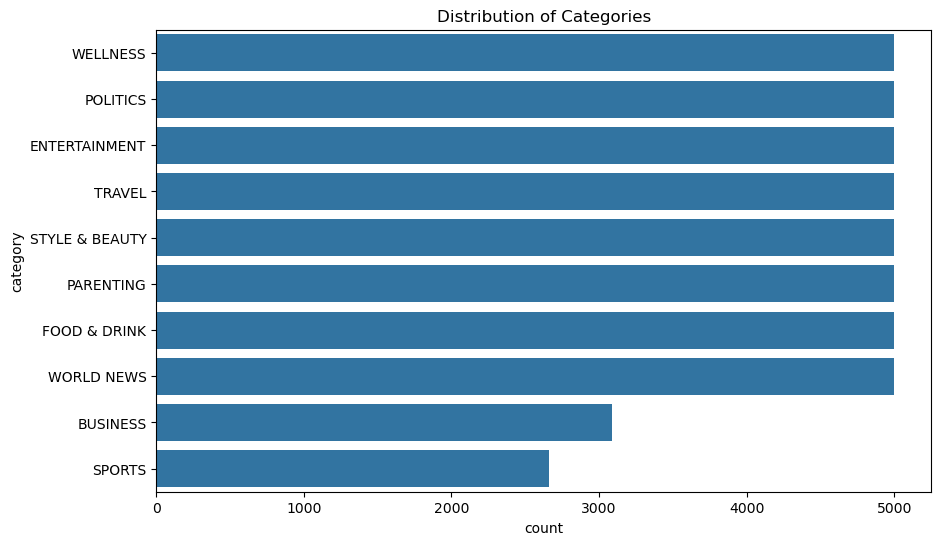

In [50]:
plt.figure(figsize=(10,6))
sns.countplot(y='category', data=na, order=na['category'].value_counts().index)
plt.title('Distribution of Categories')
plt.show()

In [52]:
tfidf_vectorizers = {}
tfidf_features_list = []

for col in text_cols:
    vectorizer = TfidfVectorizer(max_features=5000)  # Limit top 5000 words per column
    tfidf_features = vectorizer.fit_transform(na[col])
    tfidf_vectorizers[col] = vectorizer
    tfidf_features_list.append(tfidf_features)

In [53]:
text_cols = ['cleaned_headline', 'cleaned_short_description', 'cleaned_keywords']


In [54]:
# Combine into one sparse matrix
X_text = hstack(tfidf_features_list)
print("Shape of combined TF-IDF features:", X_text.shape)


Shape of combined TF-IDF features: (45749, 15000)


# Modelling

In [66]:
y = na['category']  # Target column

X_train, X_test, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42, stratify=y
)


In [68]:
smote = SMOTE(random_state=42)

X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", np.bincount(y_train.factorize()[0]))  # original counts
print("After SMOTE:", np.bincount(y_train_res.factorize()[0]))  # resampled counts

Before SMOTE: [4000 4000 2126 4000 4000 4000 2473 4000 4000 4000]
After SMOTE: [4000 4000 4000 4000 4000 4000 4000 4000 4000 4000]


# Logistic Regression: 

In [71]:
lr = LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear')

# Hyperparameter grid
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

grid_lr = GridSearchCV(lr, param_grid_lr, cv=5, scoring='f1_macro', n_jobs=-1, verbose=1)
grid_lr.fit(X_train_res, y_train_res)


Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=1000, solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear']},
             scoring='f1_macro', verbose=1)

In [73]:
best_lr = grid_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test)

print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))

Logistic Regression Results:
                precision    recall  f1-score   support

      BUSINESS       0.69      0.69      0.69       618
 ENTERTAINMENT       0.79      0.83      0.81      1000
  FOOD & DRINK       0.86      0.88      0.87      1000
     PARENTING       0.79      0.82      0.80      1000
      POLITICS       0.81      0.79      0.79      1000
        SPORTS       0.79      0.77      0.78       532
STYLE & BEAUTY       0.90      0.84      0.87      1000
        TRAVEL       0.82      0.82      0.82      1000
      WELLNESS       0.81      0.80      0.80      1000
    WORLD NEWS       0.84      0.84      0.84      1000

      accuracy                           0.81      9150
     macro avg       0.81      0.81      0.81      9150
  weighted avg       0.81      0.81      0.81      9150

Confusion Matrix:
 [[429  25  10  23  40   7   9  25  33  17]
 [ 10 826  11  30  29  26  25  17  16  10]
 [  5  15 882  12   8   7  12  33  24   2]
 [ 24  35  16 816  13  11  13  23  4

In [75]:
print("Best Logistic Regression Parameters:", grid_lr.best_params_)

Best Logistic Regression Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}


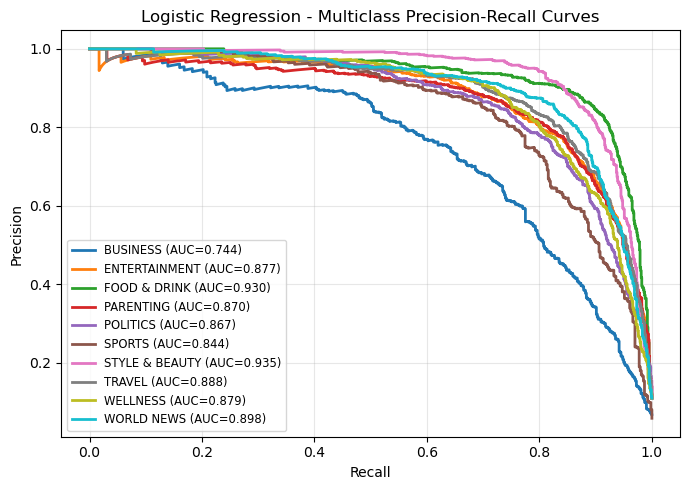

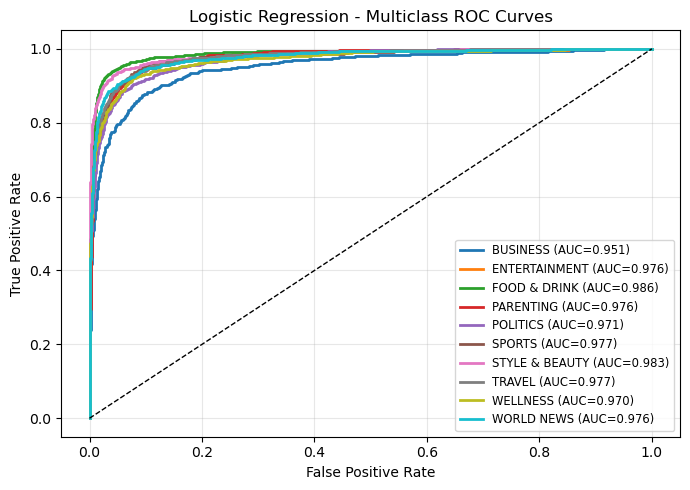

In [185]:
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
# --- Get predicted probabilities
y_scores_lr = best_lr.predict_proba(X_test)

# --- Precision-Recall Curves ---
plt.figure(figsize=(7, 5))
for i, class_name in enumerate(classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_scores_lr[:, i])
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, lw=2, label=f'{class_name} (AUC={pr_auc:.3f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Logistic Regression - Multiclass Precision-Recall Curves')
plt.legend(loc='best', fontsize='small')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --- ROC Curves ---
plt.figure(figsize=(7, 5))
for i, class_name in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_scores_lr[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{class_name} (AUC={roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression - Multiclass ROC Curves')
plt.legend(loc='best', fontsize='small')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Naive Bayes (Multinomial)

In [130]:
nb = MultinomialNB()

param_grid_nb = {
    'alpha': [0.1, 0.5, 1.0]
}

grid_nb = GridSearchCV(nb, param_grid_nb, cv=5, scoring='f1_macro', n_jobs=-1, verbose=1)
grid_nb.fit(X_train_res, y_train_res)

best_nb = grid_nb.best_estimator_
y_pred_nb = best_nb.predict(X_test)

print("Naive Bayes Results:")
print(classification_report(y_test, y_pred_nb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Naive Bayes Results:
                precision    recall  f1-score   support

      BUSINESS       0.66      0.67      0.67       618
 ENTERTAINMENT       0.82      0.78      0.80      1000
  FOOD & DRINK       0.86      0.87      0.87      1000
     PARENTING       0.71      0.81      0.76      1000
      POLITICS       0.81      0.78      0.79      1000
        SPORTS       0.80      0.77      0.79       532
STYLE & BEAUTY       0.87      0.83      0.85      1000
        TRAVEL       0.79      0.81      0.80      1000
      WELLNESS       0.80      0.79      0.79      1000
    WORLD NEWS       0.85      0.84      0.84      1000

      accuracy                           0.80      9150
     macro avg       0.80      0.79      0.80      9150
  weighted avg       0.80      0.80      0.80      9150

Confusion Matrix:
 [[416  11  10  50  42   6   7  20  38  18]
 [ 16 776   9  44  29  22  53  28  14   9]
 [  5  11 867  27   5   4  

In [149]:
print("Best Naive Bayes  Parameters:", grid_nb.best_params_)

Best Naive Bayes  Parameters: {'alpha': 0.5}


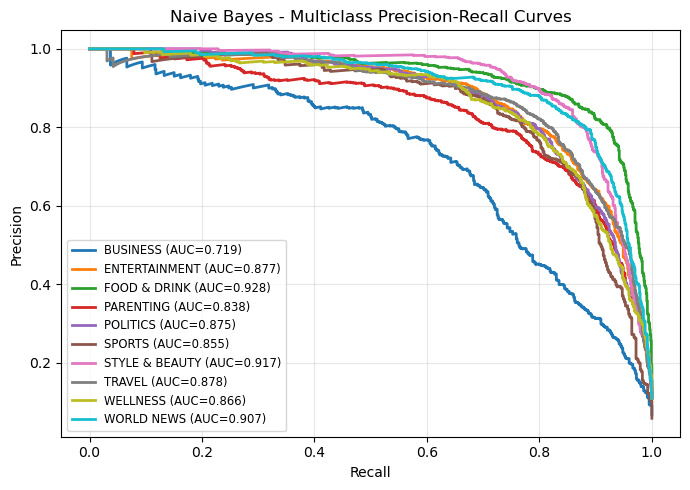

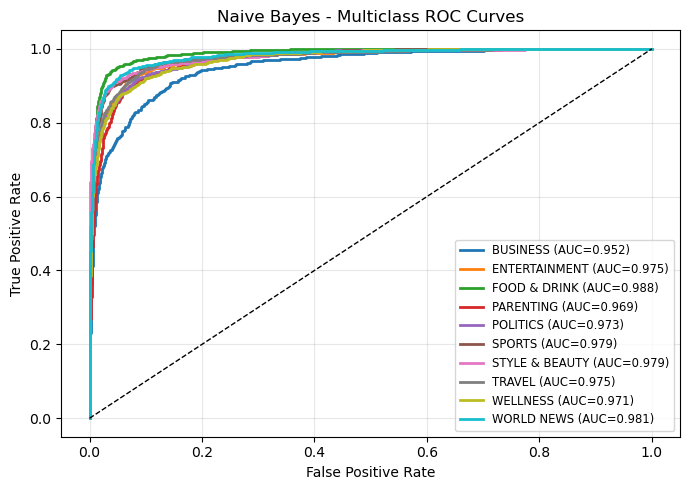

In [187]:
y_scores_nb = best_nb.predict_proba(X_test)

# --- Precision-Recall Curves ---
plt.figure(figsize=(7, 5))
for i, class_name in enumerate(classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_scores_nb[:, i])
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, lw=2, label=f'{class_name} (AUC={pr_auc:.3f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Naive Bayes - Multiclass Precision-Recall Curves')
plt.legend(loc='best', fontsize='small')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --- ROC Curves ---
plt.figure(figsize=(7, 5))
for i, class_name in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_scores_nb[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{class_name} (AUC={roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Naive Bayes - Multiclass ROC Curves')
plt.legend(loc='best', fontsize='small')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Support Vector Machine (SVM)

In [136]:
svm = SVC()

param_grid_svm = {
    'C': [0.1, 1],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale']
}

grid_svm = GridSearchCV(svm, param_grid_svm, cv=5, scoring='f1_macro', n_jobs=-1, verbose=3)
grid_svm.fit(X_train_res, y_train_res)

best_svm = grid_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test)

print("SVM Results:")
print(classification_report(y_test, y_pred_svm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))


Fitting 5 folds for each of 4 candidates, totalling 20 fits
SVM Results:
                precision    recall  f1-score   support

      BUSINESS       0.73      0.63      0.68       618
 ENTERTAINMENT       0.74      0.85      0.79      1000
  FOOD & DRINK       0.86      0.86      0.86      1000
     PARENTING       0.78      0.82      0.80      1000
      POLITICS       0.78      0.79      0.79      1000
        SPORTS       0.85      0.70      0.77       532
STYLE & BEAUTY       0.92      0.82      0.87      1000
        TRAVEL       0.78      0.81      0.79      1000
      WELLNESS       0.78      0.80      0.79      1000
    WORLD NEWS       0.83      0.85      0.84      1000

      accuracy                           0.81      9150
     macro avg       0.81      0.79      0.80      9150
  weighted avg       0.81      0.81      0.80      9150

Confusion Matrix:
 [[387  31  11  26  58   3   6  24  47  25]
 [ 10 854   9  27  30  13  15  20  10  12]
 [  5  20 861  16   8   4  13  42  

In [147]:
print("Best SVM Parameters:", grid_svm.best_params_)

Best SVM Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}


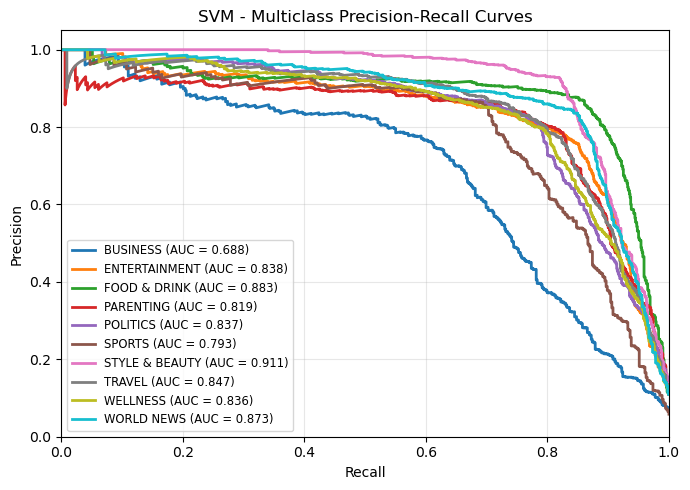

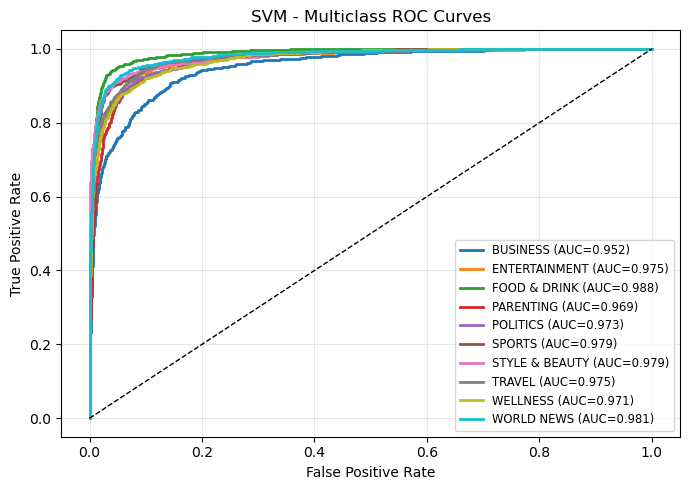

In [197]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize the output for multiclass
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
y_scores = best_svm.decision_function(X_test)  # For SVM

# Get class names
class_names = best_svm.classes_

# Plot PR curve for each class
plt.figure(figsize=(7, 5))

for i, class_name in enumerate(class_names):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_scores[:, i])
    
    # Calculate AUC
    pr_auc = auc(recall, precision)
    
    plt.plot(recall, precision, lw=2, 
             label=f'{class_name} (AUC = {pr_auc:.3f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('SVM - Multiclass Precision-Recall Curves')
plt.legend(loc='best', fontsize='small')
plt.grid(alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 5))
for i, class_name in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_scores_nb[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{class_name} (AUC={roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM - Multiclass ROC Curves')
plt.legend(loc='best', fontsize='small')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Cross-Validations

In [193]:
models = {'Logistic Regression': best_lr, 'Naive Bayes': best_nb, 'SVM': best_svm}

In [145]:
for name, model in models.items():
    pipeline = Pipeline([('smote', smote), ('model', model)])
    cv_scores = cross_val_score(pipeline, X_text, y, cv=5, scoring='f1_macro')
    print(f"{name} 5-Fold CV F1 Macro Scores: {cv_scores}")
    print(f"{name} Mean CV F1 Macro Score: {np.mean(cv_scores):.4f}\n")

Logistic Regression 5-Fold CV F1 Macro Scores: [0.80315809 0.80692264 0.80318348 0.80477424 0.8054712 ]
Logistic Regression Mean CV F1 Macro Score: 0.8047

Naive Bayes 5-Fold CV F1 Macro Scores: [0.78750686 0.79551489 0.79305324 0.80187797 0.79643708]
Naive Bayes Mean CV F1 Macro Score: 0.7949

SVM 5-Fold CV F1 Macro Scores: [0.79009784 0.79217083 0.78962214 0.79575064 0.79317024]
SVM Mean CV F1 Macro Score: 0.7922



In [201]:
cv_results = {
    'Logistic Regression': [0.80315809, 0.80692264, 0.80318348, 0.80477424, 0.8054712],
    'Naive Bayes': [0.78750686, 0.79551489, 0.79305324, 0.80187797, 0.79643708],
    'SVM': [0.79009784, 0.79217083, 0.78962214, 0.79575064, 0.79317024]
}

# Convert to DataFrame for plotting
cv_df = pd.DataFrame(cv_results)
cv_df

,Logistic Regression,Naive Bayes,SVM
0,0.803158,0.787507,0.790098
1,0.806923,0.795515,0.792171
2,0.803183,0.793053,0.789622
3,0.804774,0.801878,0.795751
4,0.805471,0.796437,0.793170


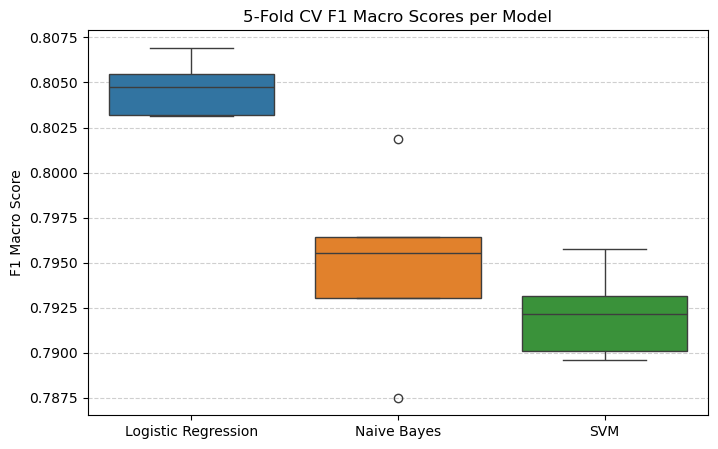

In [203]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=cv_df)
plt.title("5-Fold CV F1 Macro Scores per Model")
plt.ylabel("F1 Macro Score")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

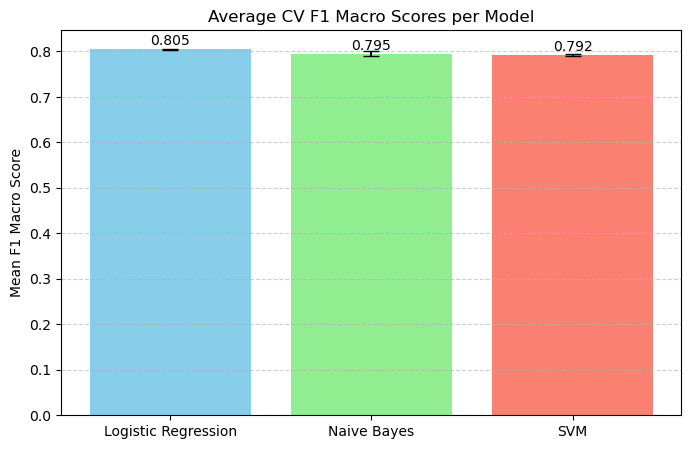

In [205]:
means = cv_df.mean()
stds = cv_df.std()

plt.figure(figsize=(8, 5))
bars = plt.bar(cv_df.columns, means, yerr=stds, capsize=6, color=['skyblue','lightgreen','salmon'])

# Add value labels
for bar, score in zip(bars, means):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
             f'{score:.3f}', ha='center', va='bottom', fontsize=10)

plt.title("Average CV F1 Macro Scores per Model")
plt.ylabel("Mean F1 Macro Score")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# Observations

- Logistic Regression gives the most balanced performance across all classes (macro F1 = 0.81) and maintains strong accuracy (0.81).

- SVM is slightly better for certain high-precision classes but has more variability in recall.

- Naive Bayes is fast and decent but slightly lower in overall accuracy and F1.

- For a robust multiclass classification, Logistic Regression is the best choice here.



In [121]:
# 1. Check available vectorizer keys
print("Available vectorizer keys:", list(tfidf_vectorizers.keys()))

# 2. Define preprocessing function
def preprocess_new_text(headline, description, keywords):
    """
    Preprocess new text data using the same preprocessing steps
    """
    cleaned_headline = preprocessor.preprocess_pipeline(headline)
    cleaned_description = preprocessor.preprocess_pipeline(description)
    cleaned_keywords = preprocessor.preprocess_pipeline(keywords)
    
    return cleaned_headline, cleaned_description, cleaned_keywords

# 3. Define feature transformation function
def transform_new_features(cleaned_headline, cleaned_description, cleaned_keywords):
    """
    Transform new text data using the trained TF-IDF vectorizers
    """
    # Use the correct keys based on what's available
    headline_features = tfidf_vectorizers['headline'].transform([cleaned_headline])
    description_features = tfidf_vectorizers['short_description'].transform([cleaned_description])
    keywords_features = tfidf_vectorizers['keywords'].transform([cleaned_keywords])
    
    # Combine all features
    combined_features = hstack([headline_features, description_features, keywords_features])
    
    return combined_features

# 4. Define prediction function
def predict_news_category(headline, short_description, keywords):
    """
    Predict news category for new data
    """
    # Preprocess the new text
    cleaned_headline, cleaned_description, cleaned_keywords = preprocess_new_text(
        headline, short_description, keywords
    )
    
    # Transform features
    new_features = transform_new_features(
        cleaned_headline, cleaned_description, cleaned_keywords
    )
    
    # Make prediction
    predicted_category = best_lr.predict(new_features)[0]
    prediction_probabilities = best_lr.predict_proba(new_features)[0]
    
    # Get confidence scores for all categories
    categories = best_lr.classes_
    confidence_scores = {category: prob for category, prob in zip(categories, prediction_probabilities)}
    
    return predicted_category, confidence_scores

# 5. Test prediction
new_headline = "Stock Markets Reach All-Time High Amid Economic Recovery"
new_description = "Global stock markets surged to record levels as economic indicators show strong recovery signals across multiple sectors."
new_keywords = "stock-market-economic-recovery"

# Make prediction
predicted_category, confidence_scores = predict_news_category(
    new_headline, new_description, new_keywords
)

print(f"Predicted Category: {predicted_category}")
print("Confidence Scores:")
for category, score in sorted(confidence_scores.items(), key=lambda x: x[1], reverse=True):
    print(f"  {category}: {score:.4f}")

Available vectorizer keys: ['headline', 'short_description', 'keywords']
Predicted Category: BUSINESS
Confidence Scores:
  BUSINESS: 0.7179
  FOOD & DRINK: 0.0807
  ENTERTAINMENT: 0.0757
  WORLD NEWS: 0.0474
  POLITICS: 0.0272
  SPORTS: 0.0216
  WELLNESS: 0.0140
  TRAVEL: 0.0085
  STYLE & BEAUTY: 0.0046
  PARENTING: 0.0024


video link: https://drive.google.com/file/d/1vEf1XcUDxKKs4l0TCbGcmhBnv0pjqDE9/view?usp=sharing